## Phase locking/phase coherence
Questions: 
* Does TMS increase inter-trial coherence? In which frequency bands?
* Do electrodes that show real-time increases in phase locking also show increases in functional connectivity from before/after TMS session?

In [1]:
import numpy as np
import mne
import pandas as pd
import pylab as plt

# For parallel processing
import multiprocessing as mp
n_cpus = mp.cpu_count()

from codebase import good_subs

In [2]:
print(good_subs)

{'404': ['STG', 'Motor'], '405': ['STG', 'Parietal'], '416': ['Parietal', 'Parietal1', 'STG'], '423': ['Parietal'], '429': ['L_DLPFC'], '430': ['Precuneus', 'Parahippocampus', 'DLPFC'], '477': ['Parietal'], '483': ['Parietal', 'DLPFC'], '518': ['DLPFC'], '534': ['DLPFC'], '538': ['DLPFC'], '559': ['DLPFC'], '561': ['DLPFC']}


### Time-resolved analysis
Examine the timecourse of ITC for a given subject/session/electrode

First want to analyze whether TMS provokes increase in inter-trial coherence (i.e. phase locking). Important to ensure that trial numbers are matched between conditions, as PLV are biased by number of observations. Will eventually need to apply resampling methods to get statistically robust results.

In [44]:
# Set up parameters
freqs = [3, 4, 5, 6, 7, 8]  # theta
#freqs = np.arange(30, 51, 2) # gamma
fs = 500   # 500Hz sampling
sub = '559'
sess = 'DLPFC'

# Load the data
tms_dat = np.load('./TMSEEG_data/'+sub+'/'+sub+'_TMS_'+sess+'_0_5Hz_1-CleanedFilteredSubsampled.npy')  # using the -0.5 to 2 second files
sham_dat = np.load('./TMSEEG_data/'+sub+'/'+sub+'_Sham_'+sess+'_0_5Hz_1-CleanedFilteredSubsampled.npy')  # file is trials x elecs x samples 
elecs = pd.read_pickle('./TMSEEG_data/'+sub+'/'+sub+'_'+sess+'_elecs.pkl')

# Need to subsample to smallest number of trials between TMS and sham (usually TMS), because
# ITC is affected by trial count
mintrials = np.min([tms_dat.shape[0], sham_dat.shape[0]])

#Get the X-second window with a 50ms buffer from stim period -- TMS trials
tfr_tms = mne.time_frequency.tfr_array_multitaper(tms_dat[np.random.choice(tms_dat.shape[0], mintrials, replace=False), :, :], 
                                                  sfreq=fs, freqs=freqs, output='itc',
                                                  n_cycles=3, n_jobs=n_cpus)

# Now for the sham trials
tfr_sham = mne.time_frequency.tfr_array_multitaper(sham_dat[np.random.choice(sham_dat.shape[0], mintrials, replace=False), :, :],
                                                   sfreq=fs, freqs=freqs, output='itc',
                                                  n_cycles=3, n_jobs=n_cpus)  # output is elecs x freqs x samples

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 124 out of 124 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 124 out of 124 | elapsed:    1.3s finished


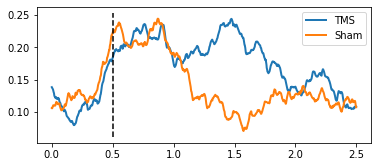

In [45]:
# Plot results
e = 34

plt.figure(figsize=(6, 2.5)); ax=plt.subplot(111)
X = np.arange(tfr_tms.shape[2])/fs
plt.plot(X, np.mean(tfr_tms[e, :, :], 0), linewidth=2, label='TMS')
plt.plot(X, np.mean(tfr_sham[e, :, :], 0), linewidth=2, label='Sham')
plt.vlines([0.5], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', linestyle='--')
plt.legend()

### Compute ITCs across all electrodes, subjects, sessions

In [4]:
def get_null_distribution(tfr_tms, tfr_sham, numshuf=100):
    tfr_sham_tms = np.concatenate([tfr_tms, tfr_sham])  #concatenate data into one large array
    arr_idxs = np.arange(tfr_sham_tms.shape[0])
    tms_len = tfr_tms.shape[0]; sham_len = tfr_sham.shape[0]
    from numpy.random import shuffle

    null_diffs = []

    for i in range(numshuf):
        shuffle(arr_idxs)
        a = tfr_sham_tms[arr_idxs[:tms_len], :, :, :]
        b = tfr_sham_tms[arr_idxs[tms_len:], :, :, :]

        a_rlv = circ.resultant_vector_length(a, axis=0)
        b_rlv = circ.resultant_vector_length(b, axis=0)

        diff = a_rlv-b_rlv
        diff = np.mean(diff, axis=1)  # average differences over frequencies

        null_diffs.append(diff)
    null_diffs = np.array(null_diffs)
    
    return null_diffs

In [ ]:
import pycircstat as circ
import os

# Set up parameters
freqs = [3, 4, 5, 6, 7, 8]  # theta
#freqs = np.arange(30, 51, 2) # gamma
fs = 500   # 500Hz sampling

for sub in list(good_subs.keys())[:]:
    for sess in good_subs[sub][:]:
        
        try:
            os.mkdir('./TMSEEG_data/'+sub+'/PLV')
        except:
            pass

        # Load the data
        tms_dat = np.load('./TMSEEG_data/'+sub+'/'+sub+'_TMS_'+sess+'_0_5Hz_1-CleanedFilteredSubsampled.npy')  # using the -0.5 to 2 second files
        sham_dat = np.load('./TMSEEG_data/'+sub+'/'+sub+'_Sham_'+sess+'_0_5Hz_1-CleanedFilteredSubsampled.npy')  # file is trials x elecs x samples 

        # Get TFR of phase from the TMS trials
        tfr_tms = mne.time_frequency.tfr_array_multitaper(tms_dat[:, :, :], 
                                                          sfreq=fs, freqs=freqs, output='phase',
                                                          n_cycles=3, n_jobs=n_cpus)

        # Now for the sham trials
        tfr_sham = mne.time_frequency.tfr_array_multitaper(sham_dat[:, :, :],
                                                           sfreq=fs, freqs=freqs, output='phase',
                                                          n_cycles=3, n_jobs=n_cpus)  # output is trials x elecs x tapers x frequencies x times

        tfr_tms = circ.mean(tfr_tms, axis=2)  #Average phase across tapers
        tfr_sham = circ.mean(tfr_sham, axis=2)

        # Generate null distribution
        null_diffs = get_null_distribution(tfr_tms, tfr_sham)

        # Compute phase locking and TMS vs sham difference
        rlv_tms = circ.resultant_vector_length(tfr_tms, axis=0)
        rlv_sham = circ.resultant_vector_length(tfr_sham, axis=0)
        tru_diff = rlv_tms-rlv_sham
        tru_diff = np.mean(tru_diff, axis=1)  # average over frequencies

        # Epoch into 100ms windows
        winsize = int(0.1*fs)
        tru_diff_epoch = np.mean(np.reshape(tru_diff, (tru_diff.shape[0], winsize, -1), order='F'), axis=1)
        null_diffs_epoch = np.mean(np.reshape(null_diffs, (null_diffs.shape[0], null_diffs.shape[1], winsize, -1), order='F'), 2)

        # Average z-score in the window of interest
        start_win = 11; end_win = start_win+9
        tru_diff_win = np.mean(tru_diff_epoch[:, start_win:end_win], 1)
        null_diffs_win = np.mean(null_diffs_epoch[:, :, start_win:end_win], 2)
        z_win = (tru_diff_win-np.mean(null_diffs_win, 0))/np.std(null_diffs_win, 0)
        
        # Save results!
        # np.save('./TMSEEG_data/'+sub+'/PLV/'+sub+'_'+sess+'_'+'ITC_Z_1p1sec_2p0sec.npy', z_win)
        # np.save('./TMSEEG_data/'+sub+'/PLV/'+sub+'_'+sess+'_'+'ITC_nulls.npy', null_diffs_epoch)
        # np.save('./TMSEEG_data/'+sub+'/PLV/'+sub+'_'+sess+'_'+'ITC_true.npy', tru_diff_epoch)

In [170]:
# Z-score PLV differences against a null distribution
z = np.empty(tru_diff_epoch.shape)

# Z-score timecourse
for i in range(tru_diff_epoch.shape[0]):
    for j in range(tru_diff_epoch.shape[1]):
        null_mu = np.mean(null_diffs_epoch[:, i, j])
        null_std = np.std(null_diffs_epoch[:, i, j])
        z[i, j] = (tru_diff_epoch[i, j]-null_mu)/null_std

### Analyze ITC across entire dataset
Analogous to t-statistic reflect TMS vs sham spectral power

In [13]:
import pandas as pd
res = pd.DataFrame()

remove_sat = True
remove_seizure = True

for sub in list(good_subs.keys())[:]:
    for sess in good_subs[sub][:]:
        
        # Load the data
        z = np.load('./TMSEEG_data/'+sub+'/PLV/'+sub+'_'+sess+'_ITC_Z_1sec_2sec.npy')
        tms_dat = np.load('./TMSEEG_data/'+sub+'/'+sub+'_TMS_'+sess+'_0_5Hz_1-CleanedFilteredSubsampled.npy')
        elecs = pd.read_pickle('./TMSEEG_data/'+sub+'/'+sub+'_'+sess+'_elecs.pkl')
        
        # Remove saturated electrodes (thresholding the TEPs)
        from codebase import get_saturated_elecs
        sat_elecs = get_saturated_elecs(tms_dat, samples=250, thresh_=5)
        
        for idx in range(len(z)):
            
            elec_dict = dict(elecs.iloc[idx])  # harvest electrode information
            
            # Flag saturated electrodes
            if idx in sat_elecs:
                sat_flag=True
            else:
                sat_flag=False
            
            mydict = {'subject': sub, 'session': sess, 'elec_idx': idx, 'Z': z[idx], 'saturated': sat_flag}
            mydict.update(elec_dict)
            
            # Update the DataFrame
            res = res.append(mydict, ignore_index=True)

# Remove saturated electrodes
if remove_sat is True:
    res = res[res['saturated']==False]
    
# Remove epileptogenic electrodes
if remove_seizure is True:
    res = res[res['Seizure_Exclude']==0]

C:\Users\esolo\AppData\Local\Temp\ipykernel_14576\1412884610.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(mydict, ignore_index=True)
C:\Users\esolo\AppData\Local\Temp\ipykernel_14576\1412884610.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(mydict, ignore_index=True)
C:\Users\esolo\AppData\Local\Temp\ipykernel_14576\1412884610.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(mydict, ignore_index=True)
C:\Users\esolo\AppData\Local\Temp\ipykernel_14576\1412884610.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(mydict, ignore_index=True)
C:\Users\eso

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Z         
No. Observations: 2813    Method:             ML        
No. Groups:       13      Scale:              0.9583    
Min. group size:  105     Log-Likelihood:     -3946.9951
Max. group size:  460     Converged:          Yes       
Mean group size:  216.4                                 
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   0.155     0.042  3.704  0.000   0.073   0.237
g1 Var      0.027     0.012                              



Text(0.5, 1.0, 'Z-scored ITC across subjects/sessions')

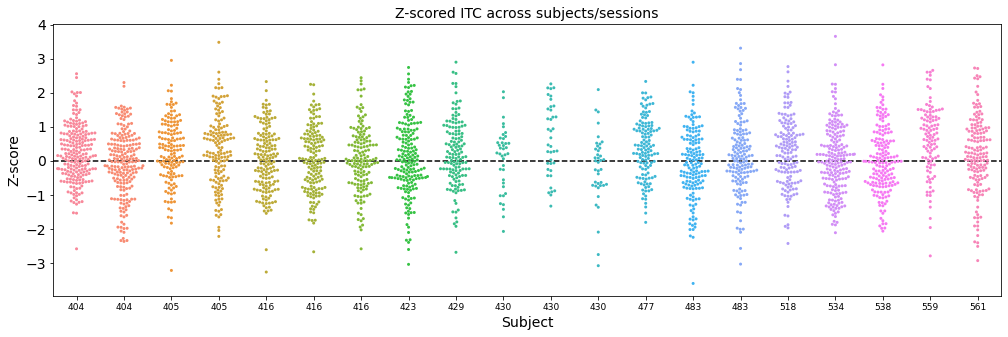

In [14]:
from utils import swarmplot_subjects
import statsmodels.api as sm
import seaborn as sns

# Need to drop some electrodes with NaNs (small amount of source EEG data contaminated with NaNs)
res_dropna = res.dropna(subset='Z')

# Sessions nested within subjects LMM, specifying subjects as random effects
vcf = {'g1':'0+C(session)'}
model = sm.MixedLM.from_formula("Z ~ 1", data=res_dropna, 
                                vc_formula=vcf,
                                groups='subject')
result = model.fit(reml=False)
print(result.summary())

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(res, key='Z')   # Reformats the data for easy plotting!
plt.figure(figsize=(17, 5)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3,)
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=9); plt.xlabel('Subject', fontsize=14)
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14); plt.ylabel('Z-score', fontsize=14)
plt.title('Z-scored ITC across subjects/sessions', fontsize=14)

There is a very significant effect! Let's examine some in more detail. 

In [18]:
res[res['Z']>2.5]

,subject,session,elec_idx,Z,saturated,Channel,Contact,Side,Group,Number,...,anatY,anatZ,DKT_label,Destrieux_label,GM,Seizure_Exclude,Nourski_Assignment,Nourski_Anatomical,DestrieuxLabel,Notes
39,404,STG,39,2.554907,False,44,44,Left,Amygdala_depth,4,...,-4.252150,-37.158100,Left-Amygdala,Left-Amygdala,1,0,,Amygdala,NaN,NaN
543,405,STG,114,2.947676,False,203,203,Left,Superior_frontal_grid,11,...,57.624700,42.433100,Ctx-lh-superiorfrontal,Ctx_lh_G_front_sup,1,0,PFC,MFG,NaN,NaN
631,405,Parietal,50,3.477896,False,77,77,Left,Amygdala_depth,5,...,4.143665,-11.123750,Left-Amygdala,Left-Amygdala,1,0,,Amygdala,NaN,NaN
633,405,Parietal,52,2.601964,False,79,79,Left,Amygdala_depth,7,...,7.702510,-10.952400,Left-Amygdala,Left-Amygdala,1,0,,Amygdala,NaN,NaN
1345,423,Parietal,60,2.739599,False,77,77,Left,Posterior_insula_depth,3,...,-24.871400,6.259630,Ctx-lh-superiortemporal,Ctx_lh_S_temporal_transverse,1,0,,PT,NaN,NaN
1439,423,Parietal,154,2.549833,False,183,183,Left,Frontal_grid,23,...,-6.789780,30.004300,Ctx-lh-precentral,Ctx_lh_G_precentral,1,0,,IFG p. opercularis,NaN,NaN
1583,429,L_DLPFC,95,2.563646,False,175,175,Right,Superior_lateral_frontal_grid,15,...,2.596910,45.398520,Ctx-rh-precentral,NaN,1,0,NaN,NaN,Ctx rh G precentral,NaN
1596,429,L_DLPFC,108,2.895010,False,190,190,Right,Inferior_lateral_frontal_grid,14,...,15.045908,23.093420,Ctx-rh-parsopercularis,NaN,1,0,NaN,NaN,Ctx rh G front inf-Opercular,NaN
1636,429,L_DLPFC,148,2.600642,False,233,233,Right,Posterior_hippocampus_depth,9,...,11.266513,-24.171430,Right-Hippocampus,NaN,0,0,NaN,NaN,Right-Hippocampus,NaN
2098,483,Parietal,110,2.893410,False,142,142,Left,amygdala_depth,8,...,5.331355,-10.360530,Ctx-lh-insula,Ctx_lh_G_oc-temp_med-Parahip,1,0,,PHG,NaN,


* Unclear if 416, elec 181 is natural or artifactual response (seems to be some stim-like events later in the interval, but not exactly. Electrode is in SOZ so ideally will remove.
* Some subjects/electrodes have a bit of a discontinuity shortly after the 1 sec mark that is concerningly stereotyped. Introduced by the artifact reduction algorithm maybe? 